Read in image

Get boundaries of image with bounding box

Crop image

Feed to edge detection

Feed to classification

In [195]:
import sys, os

import numpy as np

from PIL import Image, ImageFilter

import matplotlib.pyplot as plt
from   matplotlib.patches import Rectangle

import edge_feature_generation as efg
import generate_image_labels as giLabels
import predict_lego_class as plc

In [2]:
sys.path.append("/home/sean/Insight/legos/tensorbox")

import pred_location as pl

In [3]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline

In [4]:
my_df = giLabels.gen_dirty_labels()

In [5]:
my_df.head()

,img_path,label,height_brick,height_plate,height_other,shape_corner,shape_round,shape_square,short_1,short_2,...,short_6,short_8,long_1,long_2,long_3,long_4,long_6,long_8,long_10,long_12
0,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
def get_img_bbox(
                    file_name    ,
                    inp_img      ,
                    box_scale=1.0,
                ):
    
    rect_list = pl.pred_lego_locations( file_name )
    
    inp_size_x = inp_img.size[0]
    inp_size_y = inp_img.size[1]
    
    fixed_rect_dict_list = []
    
    # May return multiple
    for rect in rect_list:
                
        x_mod = inp_size_x / 640.
        y_mod = inp_size_y / 480.

        # Need to expand box since fit to 640x480 image
        # Also expand borders of box 
        x_1 =  rect['x1'] * x_mod
        x_2 =  rect['x2'] * x_mod
        y_1 =  rect['y1'] * y_mod
        y_2 =  rect['y2'] * y_mod

        width = x_2 - x_1
        height= y_2 - y_1

        # Expand to the box to really make sure we have the lego
        # But make sure we don't go out of the box
        x_1 = max( x_1 + width / 2 * ( 1 - box_scale ),             0 )
        x_2 = min( x_2 - width / 2 * ( 1 - box_scale ), img.size[0]-1 )
        y_1 = max( y_1 + width / 2 * ( 1 - box_scale ),             0 ) 
        y_2 = min( y_2 - width / 2 * ( 1 - box_scale ), img.size[1]-1 )

        # Repopulate dictionary
        fixed_rect_dict_list.append(
                                    {
                                        'x1':int(x_1),
                                        'x2':int(x_2),
                                        'y1':int(y_1),
                                        'y2':int(y_2),
                                    }
                                   )
    return fixed_rect_dict_list


def plot_img_bbox(
                    inp_file,
                    bb_scale=1.0,
                    save_fig=None,
                 ):
    img = Image.open( inp_file )
    fig, ax = plt.subplots()
    ax.imshow( img )
    rect_list = get_img_bbox( file_name, img, box_scale=bb_scale )
    for rect in rect_list:
        x_1 = rect['x1']
        x_2 = rect['x2']
        y_1 = rect['y1']
        y_2 = rect['y2']
        width = x_2 - x_1
        height= y_2 - y_1
        ax.add_patch(Rectangle( 
                        (int(x_1),int(y_1)), 
                        int(width), 
                        int(height), fill=False, color='r' ) )
    if ( save_fig==None ):
        plt.show()
    else:
        plt.savefig( save_fig )
        
# Need to crop legos out of images
def crop_legos(
                inp_file_name,
                box_scale=1.0
              ):
    
    # Open the image
    inp_img = Image.open( inp_file_name )
    
    # Get the bounding boxes
    box_dict_list = get_img_bbox( inp_file_name, inp_img, box_scale=box_scale )

    # Turn into np array
    img_arr = efg.arr_from_pil( inp_img )

    # Put all the lego images in here
    img_list = []
    
    # For each box/lego found, take it
    #  out of the array
    for box in box_dict_list:
        
        # Save to a list of images
        # Images xy, np yx
        img_list.append(
                        img_arr[
                                box["y1"]:box["y2"],
                                box["x1"]:box["x2"],
                               ]
                       )
    return img_list

def generate_prediction_string(
                                inp_file_name
                              ):
    
    cropped_arr_list = crop_legos( file_name, box_scale=1.1 )
    
    block_list = []
    
    for img_arr in cropped_arr_list:
        rc_ratio, row_avg, col_avg = efg.get_img_edge_data( 
                                                            img_arr, 
                                                            edge_cutoff=50,
                                                          )
    
        feature_arr = plc.generate_feature_array( rc_ratio, row_avg, col_avg )
        
        height_str = plc.get_height_predict( feature_arr )[0].split('_')[1]
        long_str   = plc.get_short_predict ( feature_arr )[0].split('_')[1]
        short_str  = plc.get_long_predict  ( feature_arr )[0].split('_')[1]
        
        full_str = short_str+'x'+long_str+' '+height_str
        
        block_list.append( full_str )
    return block_list

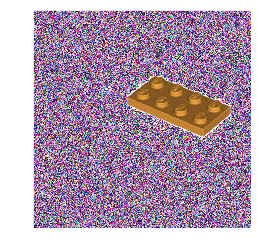

In [7]:
i = 53
file_name = my_df.loc[i,'img_path']
img = Image.open( file_name )
plt.imshow( img )
plt.show()

In [8]:
cropped_arr_list = crop_legos( file_name, box_scale=1.1 )

In [ ]:
def generate_prediction_string(
                                inp_file_name
                              ):
    
    cropped_arr_list = crop_legos( file_name, box_scale=1.1 )
    
    block_list = []
    
    for img_arr in cropped_arr_list:
        rc_ratio, row_avg, col_avg = efg.get_img_edge_data( 
                                                            img_arr, 
                                                            edge_cutoff=50,
                                                          )
    
        feature_arr = plc.generate_feature_array( rc_ratio, row_avg, col_avg )
        
        height_str = plc.get_height_predict( feature_arr )[0].split('_')[1]
        long_str   = plc.get_short_predict ( feature_arr )[0].split('_')[1]
        short_str  = plc.get_long_predict  ( feature_arr )[0].split('_')[1]
        
        full_str = short_str+'x'+long_str+' '+height_str
        
        block_list.append( full_str )
    return block_list

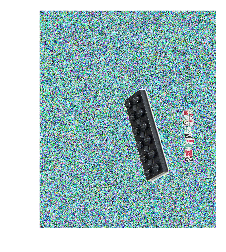

(1, 50)
['height_plate']
['short_2']
['long_1']


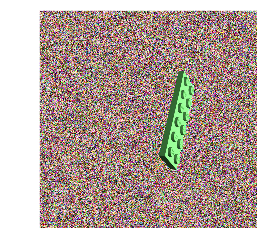

Exception KeyboardInterrupt in <function remove at 0x7f6869bfb140> ignored


(1, 50)
['height_plate']
['short_1']
['long_6']


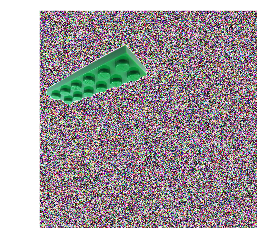

(1, 50)
['height_plate']
['short_4']
['long_1']


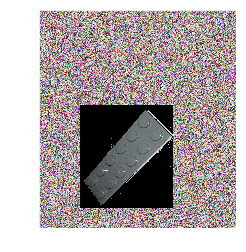

(1, 50)
['height_plate']
['short_1']
['long_6']


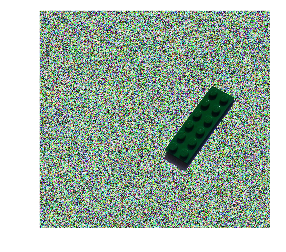

(1, 50)
['height_plate']
['short_6']
['long_10']


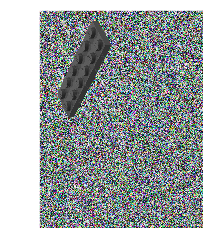

(1, 50)
['height_plate']
['short_2']
['long_8']


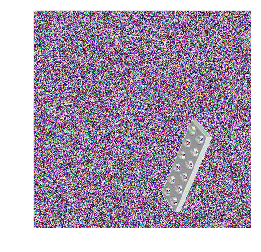

(1, 50)
['height_plate']
['short_1']
['long_6']


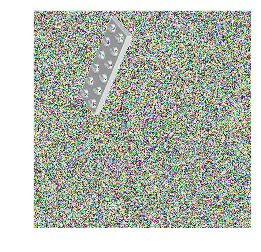

(1, 50)
['height_plate']
['short_8']
['long_8']


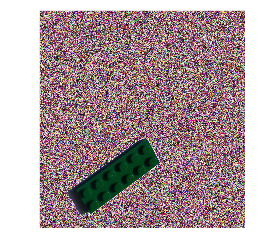

(1, 50)
['height_plate']
['short_6']
['long_6']


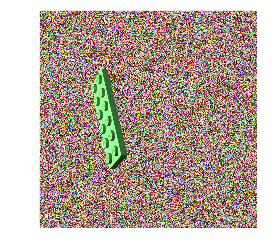

(1, 50)
['height_plate']
['short_1']
['long_6']


In [229]:
for i in range(20,30):
    file_name = my_df.loc[i,'img_path']
    img = Image.open( file_name )
    plt.imshow( img )
    plt.show()
    
    cropped_arr_list = crop_legos( file_name, box_scale=1.1 )
    
    for img_arr in cropped_arr_list:
        rc_ratio, row_avg, col_avg = efg.get_img_edge_data( 
                                                            img_arr, 
                                                            edge_cutoff=50,
                                                          )
    
        feature_arr = plc.generate_feature_array( rc_ratio, row_avg, col_avg )
        
        print plc.get_height_predict( feature_arr )
        print plc.get_short_predict ( feature_arr )
        print plc.get_long_predict  ( feature_arr )